In [1]:
# Checking the images and labels
from google.colab import drive
drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Colab Notebooks/Sraping/Scraping/Images'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Reading all the images from the folders

import cv2
import os
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
import random
import matplotlib.pyplot as plt

image_data=[]
labels=[]
# Read the data inside the three folders

for label,item in tqdm(enumerate(os.listdir(file_path))):
  if item.find('.')<0:
    for images in os.listdir(file_path+'/'+item):
      # Reaad the images
      im=cv2.imread(file_path+'/'+item+'/'+images)
      # Convert the image into numpy array
      im=np.array(im)
      # Appending the image to the dataset
      image_data.append(im)
      # Creating the label for the image
      labels.append(label)

      # Save the numpy array with labels


3it [00:16,  5.58s/it]


In [3]:
image_data=np.array(image_data)
set(labels)

{0, 1, 2}

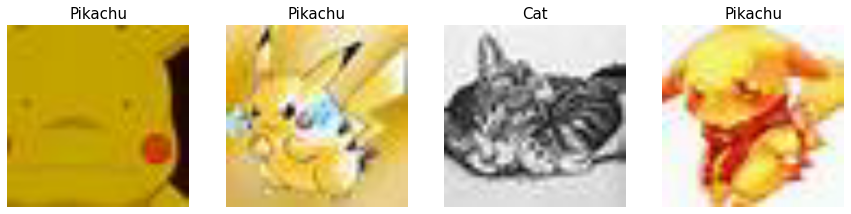

In [4]:
# Creating a dictionary for labels
dict={0:'Cat',1:'Kanye West',2:'Pikachu'}

# Testing if the images are labelled correctly
sampled_index=random.sample(list(np.arange(len(image_data))),4)

# Creating subplot for 4 images
plt.figure(figsize=(15,5))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(image_data[sampled_index[i]])
  plt.title(dict[labels[sampled_index[i]]],fontsize=15)
  plt.axis('off')

In [5]:

# Image Augmentations.
# In this case, we will be adding Horizontal Flip, rotate 45 anticlockwise, rotate 45 anticlockwise and increased brightness.

def augmentations(data):
  ''' The function will take a dataset, apply 4 transformations and share the data back'''

  flipped=[]
  clockw=[]
  anticlockw=[]
  bright=[]

  for image in tqdm(data):
    flipped.append(horizontal_flip(image))
    clockw.append(clockwise(image))
    anticlockw.append(anticlockwise(image))
    bright.append(brightness(image))

  return np.array(flipped),np.array(clockw),np.array(anticlockw),np.array(bright)


# Function for horizontal flip
def horizontal_flip(image):
  return cv2.flip(image,1)

# Function for 45 degree clockwise rotation
def clockwise(image):
  rot_matrix=cv2.getRotationMatrix2D((image.shape[0]/2,image.shape[1]/2),45,1)  # Midpoints, angle,scale
  im=cv2.warpAffine(image,rot_matrix,(image.shape[1],image.shape[0]))
  return im

# Function for 45 degree anticlockwise rotation
def anticlockwise(image):
  rot_matrix=cv2.getRotationMatrix2D((image.shape[0]/2,image.shape[1]/2),-45,1)  # Midpoints, angle,scale
  im=cv2.warpAffine(image,rot_matrix,(image.shape[1],image.shape[0]))
  return im

# Function for increasing brightness
def brightness(image):
  return cv2.addWeighted(image,0.8,image,0.9,0)

In [6]:
flipped,clock,anticlock,bright=augmentations(image_data)

100%|██████████| 1058/1058 [00:01<00:00, 599.86it/s]


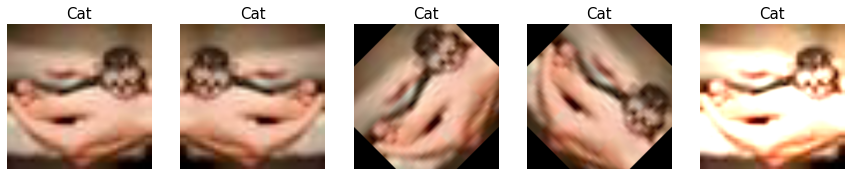

In [7]:
# checking the images
pos=random.sample(list(np.arange(len(image_data))),1)[0]
plot_data=[image_data[pos],flipped[pos],clock[pos],anticlock[pos],bright[pos]]

# Creating subplot for 4 images
plt.figure(figsize=(15,5))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(plot_data[i])
  plt.title(dict[labels[pos]],fontsize=15)
  plt.axis('off')

In [8]:
# Appending all the data
image_data=np.array(image_data)
labels=np.array(labels)
data=np.vstack((image_data,flipped,clock,anticlock,bright))
classes=np.hstack((labels,labels,labels,labels,labels))

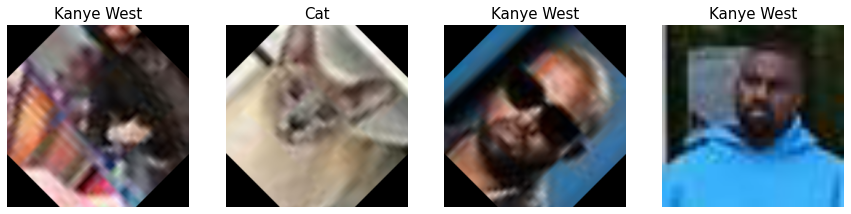

In [9]:
# Checking integrity of data
# Creating a dictionary for labels

# Testing if the images are labelled correctly
sampled_index=random.sample(list(np.arange(len(data))),4)

# Creating subplot for 4 images
plt.figure(figsize=(15,5))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.imshow(data[sampled_index[i]])
  plt.title(dict[classes[sampled_index[i]]],fontsize=15)
  plt.axis('off')

In [35]:
# One Hot Encoding the classes
Y=np.zeros((len(classes),3))
for i,value in enumerate(classes):
  Y[i][value]=1


In [12]:
cat=0
kanye=0
pikachu=0
for i in classes:
  if i==0:
    cat+=1
  elif i==1:
    kanye+=1
  elif i==2:
    pikachu+=1
print(cat,kanye,pikachu)

1360 2045 1885


# Using transfer Learning from VGG 16 

In [14]:
# Loading the VGG NET model for transfer learning. 
from keras import Input
from keras.applications.vgg16 import VGG16
from keras.models import Model


new_input = Input(shape=(250, 250, 3)) 
base_model=VGG16(weights='/content/drive/MyDrive/Colab Notebooks/Sraping/Scraping/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',input_tensor=new_input,include_top=False, pooling='avg')

In [17]:
# Since images and ImageNet images are very similiar we are only more layers
# model=Model(inputs=base_model.layers[0].input,outputs=base_model.get_layer('block5_pool').output)
model=Model(inputs=base_model.layers[0].input,outputs=base_model.get_layer('global_average_pooling2d').output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0   

In [18]:
# # Creating embedding from VGG 15 for the images
embedding=[]
for image in tqdm(data):
  embedding.append(model.predict(np.expand_dims(image,axis=0)))



100%|██████████| 5290/5290 [10:01<00:00,  8.80it/s]


In [28]:
# Saving the embedding for faser load
# np.savez('/content/drive/MyDrive/Colab Notebooks/Sraping/Scraping/embedding_full.npz',data=embedding)

embedding=np.load('/content/drive/MyDrive/Colab Notebooks/Sraping/Scraping/embedding_full.npz')
embedding=embedding['data']

In [86]:
embedding,Y=shuffle(np.array(embedding),np.array(Y))
x_train=embedding[0:5000]
y_train=Y[0:5000]
x_test=embedding[5000:]
y_test=Y[5000:]

In [87]:
# Creating a top layer

from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D,Dense,Flatten
top_layer=Sequential()
top_layer.add(Dense(256,input_shape=(1,512),activation='relu'))
top_layer.add(Dense(64,activation='relu'))
top_layer.add(Dense(8,activation='relu'))
top_layer.add(Dense(3,activation='softmax'))


In [88]:
# from tensorflow import keras
# optimizer = keras.optimizers.Adam(lr=0.01)
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping


top_layer.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

callbacks = [ModelCheckpoint('top_layer_best_weights_new.h5', monitor='val_accuracy', verbose=1, save_best_only=True)]
history=top_layer.fit(x_train,y_train,epochs=20,verbose=1,
                      validation_data=(x_test,y_test),
                      callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 0.7712 - accuracy: 0.6772
Epoch 1: val_accuracy improved from -inf to 0.74138, saving model to top_layer_best_weights_new.h5
157/157 [==============================] - 2s 9ms/step - loss: 0.7712 - accuracy: 0.6772 - val_loss: 0.6794 - val_accuracy: 0.7414
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.7266
Epoch 2: val_accuracy improved from 0.74138 to 0.75517, saving model to top_layer_best_weights_new.h5
157/157 [==============================] - 1s 7ms/step - loss: 0.6559 - accuracy: 0.7266 - val_loss: 0.6253 - val_accuracy: 0.7552
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.6080 - accuracy: 0.7364
Epoch 3: val_accuracy improved from 0.75517 to 0.76207, saving model to top_layer_best_weights_new.h5
157/157 [==============================] - 1s 7ms/step - loss: 0.6080 - accuracy: 0.7364 - val_loss: 0.5820 - val_accuracy: 0.7621
Epoch 4/20
156/1

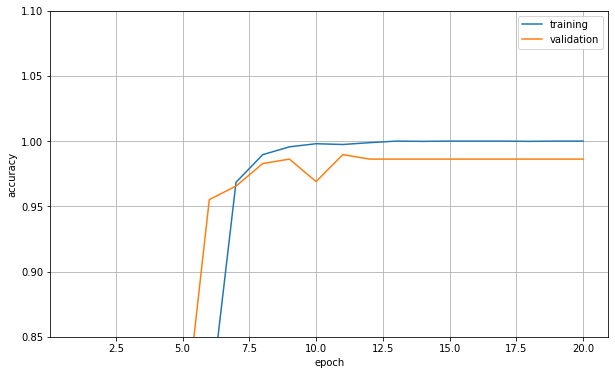

In [89]:
import pandas as pd
acc = pd.DataFrame({'epoch': range(1,21),
                    'training': history.history['accuracy'],
                    'validation': history.history['val_accuracy']})
ax = acc.plot(x='epoch', figsize=(10,6), grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.85,1.1]);


# Saving the models

In [90]:
history.model.load_weights('top_layer_best_weights_new.h5')
top_layer=history.model

In [100]:

# Saving the models
model.save('vgg_layer_final.h5')
top_layer.save('top_layer_final.h5')

# Plotting the training

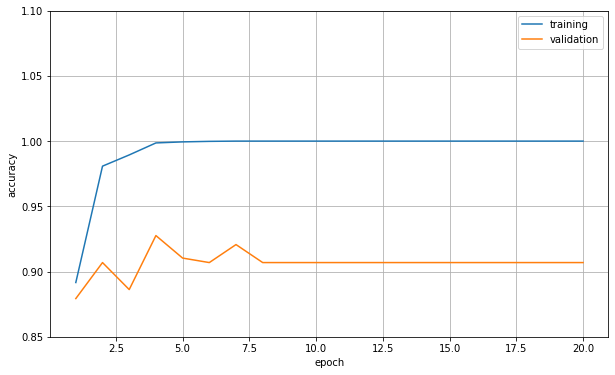

In [57]:
import pandas as pd
acc = pd.DataFrame({'epoch': range(1,21),
                    'training': history.history['accuracy'],
                    'validation': history.history['val_accuracy']})
ax = acc.plot(x='epoch', figsize=(10,6), grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.85,1.1]);


# Confusion matrix

In [94]:
# Confusion matrix
predictions=top_layer.predict(x_test)
prediction_class=[np.argmax(pred) for pred in predictions]
true=[np.argmax(pred) for pred in y_test]
from sklearn.metrics import confusion_matrix

matr=confusion_matrix(true,prediction_class)

In [97]:
import pandas as pd

matrix=pd.DataFrame(matr)
matrix.index=['Cat','Kanye West','Pikachu']
matrix.columns=['Cat','Kanye West','Pikachu']

In [98]:
matrix

,Cat,Kanye West,Pikachu
Cat,67,0,0
Kanye West,0,118,0
Pikachu,0,0,105
